 # Homework 4: Graph Spectra

 Implementation of spectral graph clustering algorithm described in the paper "On Spectral Clustering: Analysis and an algorithm" by Andrew Y. Ng, Michael I. Jordan, and Yair Weiss. 
 
### Data
**1.** A real graph "example1.dat" -- This data set was prepared by Ron Burt. He dug out the 1966 data collected by Coleman, Katz, and Menzel on medical innovation. They collected data from physicians in four towns in Illinois, Peoria, Bloomington, Quincy, and Galesburg.

**2.** A synthetic graph "example2.dat"

# Andrea Implementation

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy

from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

### Data reading

In [4]:
def readData(file):
    edges_list = nx.read_edgelist(file, delimiter=",", nodetype=int, data=(("weight", int), ))
    
    edges, nodes = edges_list.edges, edges_list.nodes
    edges = np.array(edges)
    nodes = np.array(nodes)

    return edges, nodes


## Spectral Clustering


### 1.Algorithm 
<img src="algorithm.png">

### 2.Implementation

Note: the Affinity matrix is computed as Adjacency matrix, i.e. $A_{ij}=1$ if i,j nodes are linked, otherwise 0.

In [40]:
class SpectralClustering:
    def __init__(self, edges, nodes):
        self.edges = edges
        self.nodes = nodes
        self.num_nodes = len(nodes)

        self.graph = nx.Graph()
        self.graph.add_nodes_from(nodes)
        self.graph.add_edges_from(edges)    

            
    def affinity_mat(self):
        ''' Adjiacency Matrix '''
        A = nx.adjacency_matrix(self.graph).todense()
        A = np.array(A)
        
        return A

    def diag_mat(self):
        ''' Diagonal Matrix D = diag(d_1, d_2, ..., d_n) where d_i = sum of the ith row of A'''
        A = self.affinity_mat()
        D = np.diag(np.sum(A, axis=1))
        return D

    def laplacian_mat(self):
        ''' Laplacian Matrix L = D^(-1/2) * A * D^(-1/2), computed according to the formula in the paper '''
        D = self.diag_mat()
        A = self.affinity_mat()
        
        # L = D ^ (-1/2) * A * D ^ (-1/2)
        D_tilde = np.linalg.inv(np.sqrt(D))
        L = np.dot(np.dot(D_tilde, A), D_tilde)
        return L

    def compute_eigen(self):
        ''' Compute the eigenvalues and eigenvectors of the Laplacian matrix '''
        L = self.laplacian_mat()
        eigen_values, eigen_vecs = scipy.linalg.eigh(L)
        return eigen_values, eigen_vecs

    
    def compute_Fiedler(self):
        ''' Compute the Fiedler vector of the Laplacian matrix L = D - A, according to wikipedia '''
        A = self.affinity_mat()
        D = self.diag_mat()
        laplace_mat = D - A
        eigen_values, eigen_vecs = scipy.linalg.eigh(laplace_mat)
        return eigen_values, eigen_vecs

    def eigen_matrix(self):
        ''' Compute the eigen matrix, which is the matrix of the first k eigenvectors of the Laplacian matrix '''
        eigen_values, eigen_vecs = self.compute_eigen()
        
        self.k = np.argmin(np.ediff1d(np.flipud(eigen_values))) + 1 # optimal k number of clusters
        print('The optimal number of clusters is: ', self.k)
        eigen_matrix = eigen_vecs[:, self.num_nodes - self.k:]

        #renormalized
        eigen_matrix_norm = np.divide(eigen_matrix, np.reshape(np.linalg.norm(eigen_matrix, axis=1), (eigen_matrix.shape[0], 1)))
        return eigen_matrix,eigen_matrix_norm

    def kmeans(self):
        ''' K-means clustering '''
        eigen_matrix, eigen_matrix_norm = self.eigen_matrix()
        #print(self.k)
        #print(eigen_matrix_norm)
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(eigen_matrix_norm)
        return kmeans.labels_

    def plot(self):
        ''' Plot the graph with the clusters '''
        kmeans = self.kmeans()
        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        G.add_edges_from(self.edges)
        nx.draw(G, node_size=10, node_color=kmeans)
        return kmeans


### Load the graph

Text(0.5, 1.0, 'Graph 2')

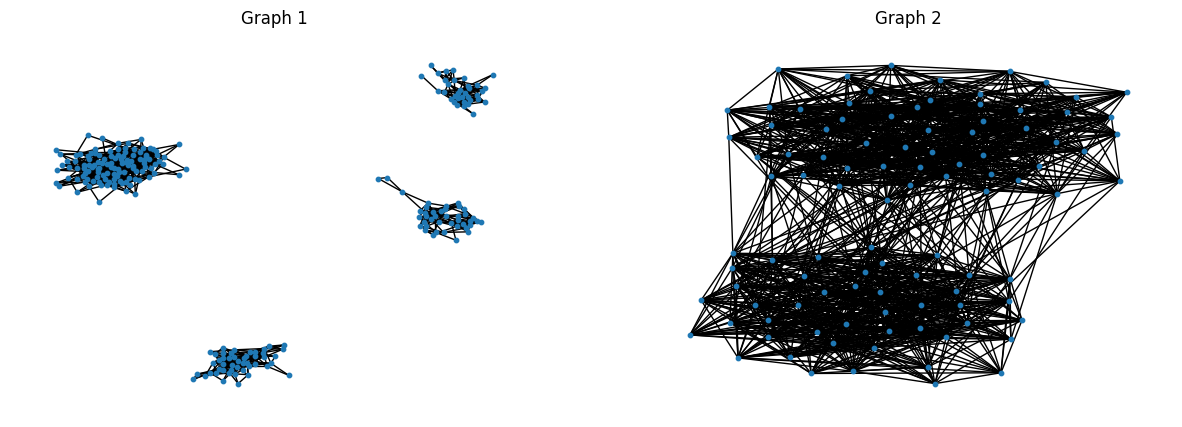

In [41]:
file1 = 'example1.dat'
file2 = 'example2.dat'
edges1, nodes1 = readData(file1)
edges2, nodes2 = readData(file2)

# add subplots for the two graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the first graph
G1 = nx.Graph()
G1.add_nodes_from(nodes1)
G1.add_edges_from(edges1)
nx.draw(G1, node_size=10, ax=ax1)
ax1.set_title('Graph 1')

# plot the second graph
G2 = nx.Graph()
G2.add_nodes_from(nodes2)
G2.add_edges_from(edges2)
nx.draw(G2, node_size=10, ax=ax2)
ax2.set_title('Graph 2')


### Run Spectral Clustering

In [42]:
sc1 = SpectralClustering(edges1, nodes1)
sc2 = SpectralClustering(edges2, nodes2)

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\863104524.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.graph).todense()


The optimal number of clusters is:  4


Text(0.5, 1.0, 'Graph 1 with clusters')

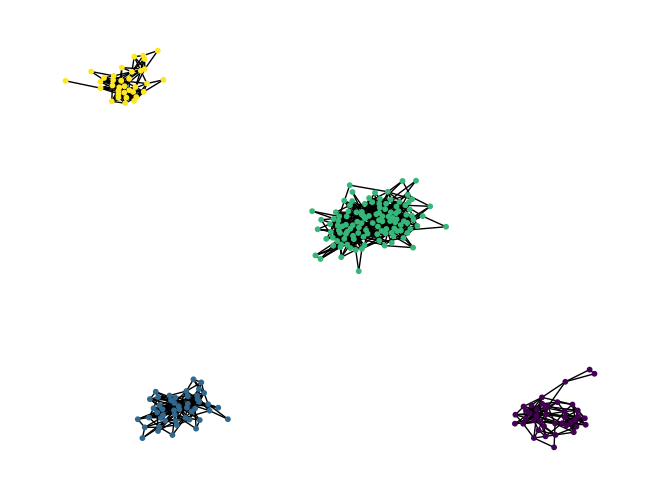

In [47]:
# plot the first graph with the clusters
kmeans1 = sc1.plot()
ax1.set_title('Graph 1 with clusters')

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\863104524.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.graph).todense()


The optimal number of clusters is:  2


Text(0.5, 1.0, 'Graph 2 with clusters')

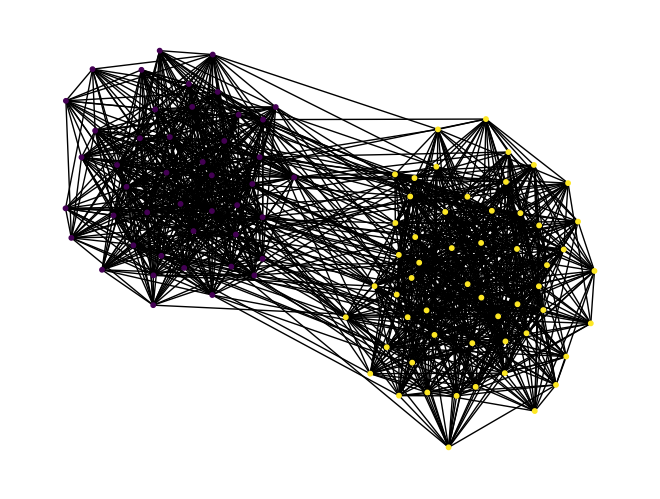

In [48]:
# plot the second graph with the clusters
kmeans2 = sc2.plot()
ax2.set_title('Graph 2 with clusters')

#### Affinity (adjacency) matrix

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\863104524.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.graph).todense()


Text(0.5, 1.0, 'Adjacency Matrix 2')

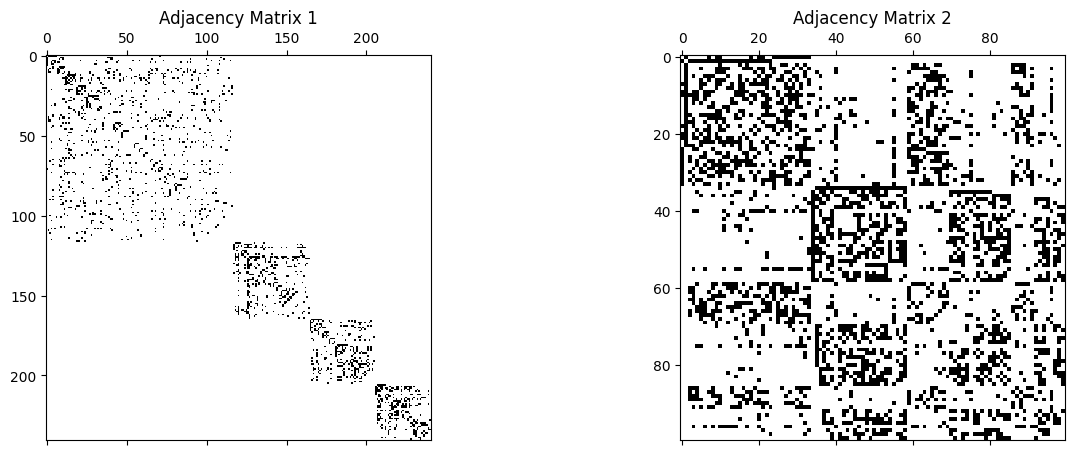

In [50]:
# show the two adjacent matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.spy(sc1.affinity_mat())
ax1.set_title('Adjacency Matrix 1')
ax2.spy(sc2.affinity_mat())
ax2.set_title('Adjacency Matrix 2')

### Fiedler vector

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\863104524.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.graph).todense()


Text(0.5, 1.0, 'Fiedler Vector 2')

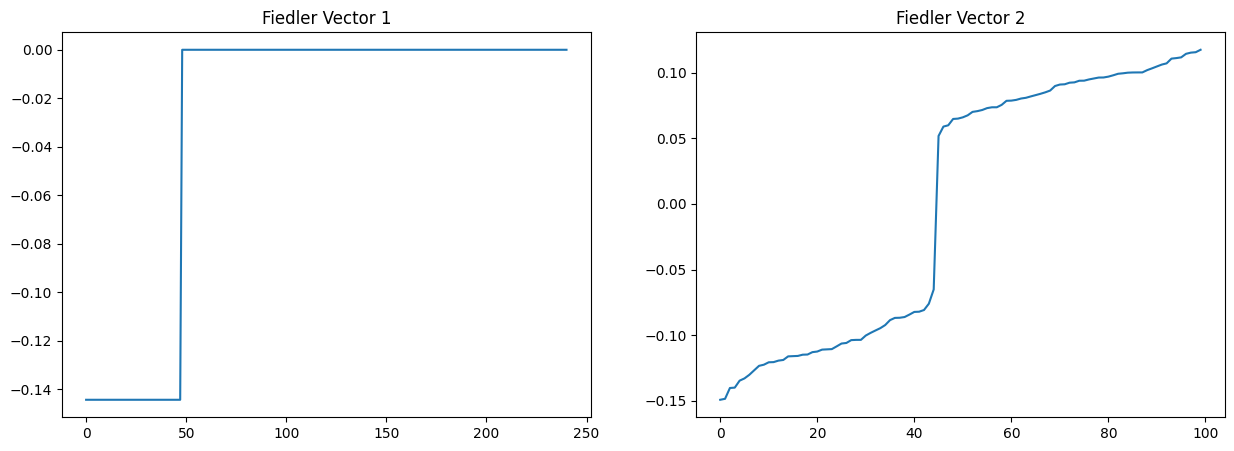

In [52]:
#show the two fiedler vectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
eigen_values1, eigen_vecs1 = sc1.compute_Fiedler()
eigen_values2, eigen_vecs2 = sc2.compute_Fiedler()

idx_order1 = list(np.argsort(eigen_values1))
idx1 = idx_order1[1]
fiedler_vec1 = eigen_vecs1[:, idx1]

idx_order2 = list(np.argsort(eigen_values2))
idx2 = idx_order2[1]
fiedler_vec2 = eigen_vecs2[:, idx2]

ax1.plot(range(len(eigen_vecs1)), sorted(fiedler_vec1))
ax1.set_title('Fiedler Vector 1')
ax2.plot(range(len(eigen_vecs2)), sorted(fiedler_vec2))
ax2.set_title('Fiedler Vector 2')


# Yutong Implementation

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx

### Read and Load the Graphs

In [12]:
data_ex1 = []
data_ex2 = []
with open('example1.dat') as f:
    for data in f:
        data_split = data.strip().split(',')
        data_ex1.append([int(element) for element in data_split])

with open('example2.dat') as f:
    for data in f:
        data_split = data.strip().split(',')
        #Because the third column(weight) are all 1s, we only consider the first 2 columns
        data_ex2.append([int(element) for element in data_split[:2]])

G_1 = nx.Graph(data_ex1)
G_2 = nx.Graph(data_ex2)

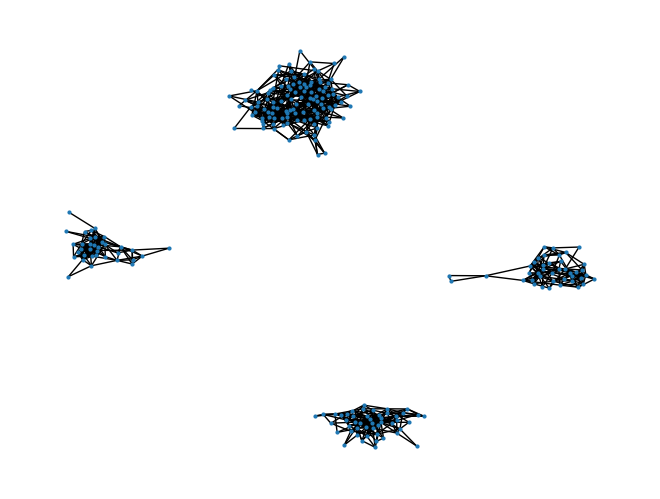

In [13]:
nx.draw(G_1, node_size = 4)

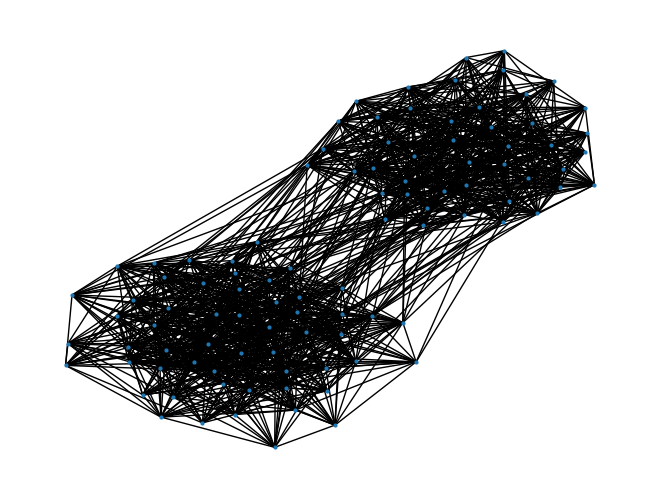

In [14]:
nx.draw(G_2, node_size = 4)

## Spectral Clustering Implementation

In [17]:
#implementation of algorithm
class spectral_cluster():
    def __init__(self, data, k):
        self.data = data
        # k stands for k largest eigenvectors
        self.k = k
    
    def affinity_mat(self):
        ''' 
        Here is the code to form the affinity matrix, although in the paper it's given in exponential form,
        for graph dataset, it should be considered as the adjacency matrix
        '''
        graph = nx.Graph(self.data)
        adj_mat = nx.adjacency_matrix(graph).todense()
        return np.array(adj_mat), graph
    
    def cal_L(self, adj_mat):
        ''' 
        ajd_mat is obtained from affinity_mat
        '''
        # D stands for the diagonal matrix
        D = np.diag(np.sum(adj_mat, axis = 1))
        tmp = np.dot(np.linalg.pinv(np.sqrt(D)), adj_mat)
        L = np.dot(tmp, np.linalg.pinv(np.sqrt(D)))
        return L, D
    
    def find_eigenvector(self, L):
        # to select k eigenvector
        eigenvalues, eigenvectors = np.linalg.eig(L)
        idx_order = list(reversed(np.argsort(eigenvalues)))
        selected_idx = idx_order[:self.k]
        selected_eigenvec = eigenvectors[:, selected_idx]
        return selected_eigenvec
    
    def normalization(self, selected_eigenvec):
        normalized_list = []
        # to normalize each row of selected eigenvectors
        for row in selected_eigenvec:
            tot = np.linalg.norm(row)
            normalized_list.append(row/tot)
        return np.array(normalized_list)

    def cluster(self, normalization, graph):
        #nx.draw(graph, node_size = 4)
        clusters = KMeans(n_clusters = self.k).fit(normalization)
        labels = clusters.labels_
        nx.draw(graph, node_size = 10, node_color = labels)
        return labels
    
    def fiedler_vec(self, D, A):
        ''' 
        Laplace matrix is calculated by D - A
        '''
        laplace_mat = D - A
        #eigh is to order the eigenvalues
        eigenvalue, eigenvectors = np.linalg.eig(laplace_mat)
        return eigenvalue, eigenvectors
    
    def forward(self):
        adj_mat, graph = self.affinity_mat()
        L, D = self.cal_L(adj_mat)
        vec = self.find_eigenvector(L)
        normalized_mat = self.normalization(vec)
        labels = self.cluster(normalized_mat, graph)
        filder_value, fiedler_vecs = self.fiedler_vec(D, adj_mat)
        return adj_mat, labels, filder_value, fiedler_vecs
    
def sparsity_pattern(A):
    plt.spy(A)

### Run Spectral Clustering

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\3790769912.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(graph).todense()


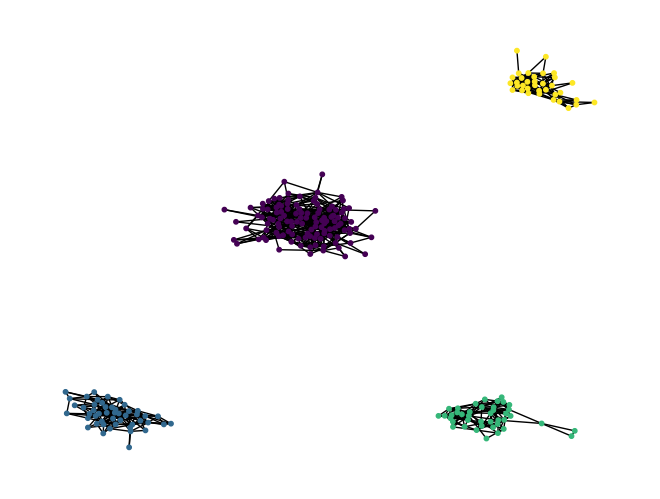

In [19]:
spec1 = spectral_cluster(data_ex1, 4)
A_1, labels, fielder_value_1, fiedler_vecs_1 = spec1.forward()

C:\Users\andre\AppData\Local\Temp\ipykernel_10832\3790769912.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_mat = nx.adjacency_matrix(graph).todense()


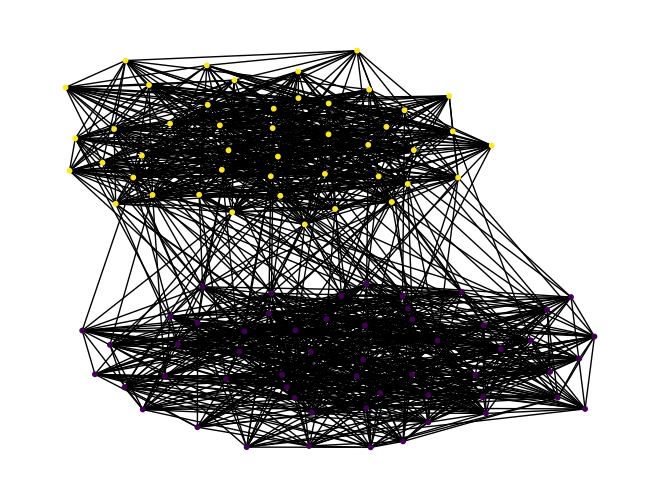

In [20]:
spec2 = spectral_cluster(data_ex2, 2)
A_2, labels, fiedler_value_2, fiedler_vecs_2 = spec2.forward()

### Affinity (adjacency) matrix

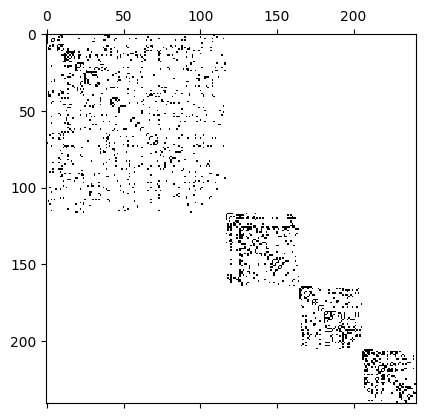

In [21]:
sparsity_pattern(A_1)

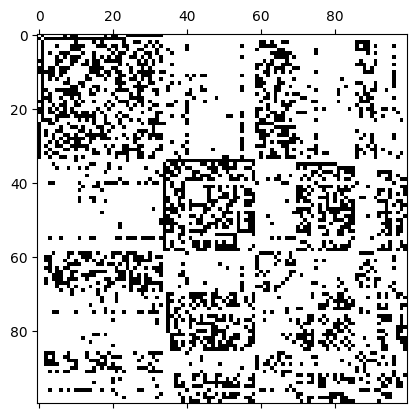

In [22]:
sparsity_pattern(A_2)

### Fiedler Vectors

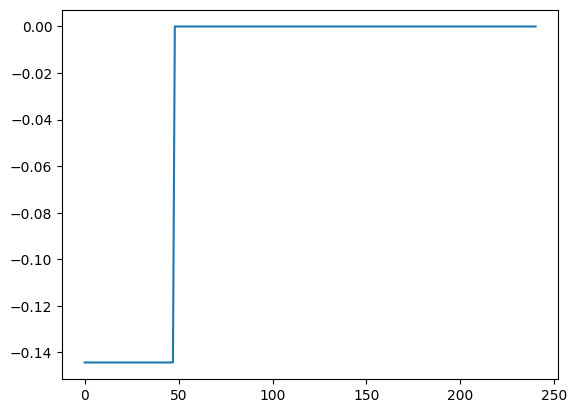

In [23]:
idx_order = list(np.argsort(fielder_value_1))
idx = idx_order[1]
fiedler_vec_1 = fiedler_vecs_1[:, idx]
plt.plot(range(len(fiedler_vecs_1)), sorted(fiedler_vec_1))

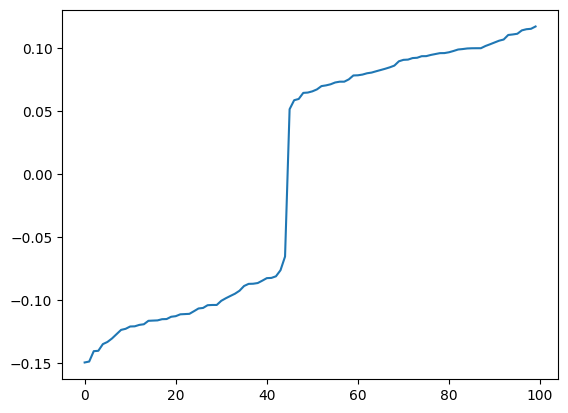

In [24]:
idx_order = list(np.argsort(fiedler_value_2))
idx = idx_order[1]
fiedler_vec_2 = fiedler_vecs_2[:, idx]
plt.plot(range(len(fiedler_vecs_2)), sorted(fiedler_vec_2))

### References

[1]  Ng, Andrew, et al. On Spectral Clustering: Analysis and an Algorithm. Edited by T Dietterich et al., MIT Press, 2001, proceedings.neurips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf.